# Event-to-Video Reconstruction with EVLib

This notebook demonstrates how to use EVLib's event-to-video reconstruction capabilities to convert event data into video frames. We'll work with the slider_depth dataset, showing:

1. Loading event data from the dataset
2. Basic event visualization
3. Reconstructing frames from events using E2VID approach
4. Creating and saving a video from reconstructed frames
5. Comparing reconstructed video with ground truth frames

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import evlib
import os
from PIL import Image
import time
from IPython.display import HTML

# Try to import cv2 for video creation
try:
    import cv2
    have_cv2 = True
except ImportError:
    have_cv2 = False
    print("OpenCV not available; some visualizations will be limited")

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better visualization
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Set data path to slider_depth dataset
data_path = "../data/slider_depth/"

## 1. Loading Event Data and Ground Truth Images

First, let's load the event data and reference images from the slider_depth dataset.

In [ ]:
def load_events(filepath):
    """Load events using evlib's formats module"""
    print(f"Loading events from {filepath} using evlib...")
    # Use evlib's data loader which automatically detects the file format
    xs, ys, ts, ps = evlib.formats.load_events(filepath)
    print(f"Loaded {len(xs)} events")
    return xs, ys, ts, ps

def load_images(image_txt_path):
    """Load image timestamps and paths"""
    print(f"Loading image info from {image_txt_path}...")
    with open(image_txt_path, 'r') as f:
        lines = f.readlines()
    
    img_timestamps = []
    img_paths = []
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 2:
            img_timestamps.append(float(parts[0]))
            img_paths.append(parts[1])
    
    print(f"Found {len(img_timestamps)} images")
    return img_timestamps, img_paths

# Load the dataset using evlib's data loader
events_path = os.path.join(data_path, "events.txt")
xs, ys, ts, ps = load_events(events_path)

# Load image info
img_timestamps, img_paths = load_images(os.path.join(data_path, "images.txt"))

# Determine sensor resolution
sensor_width = xs.max() + 1
sensor_height = ys.max() + 1
print(f"Sensor resolution: {sensor_width} x {sensor_height}")

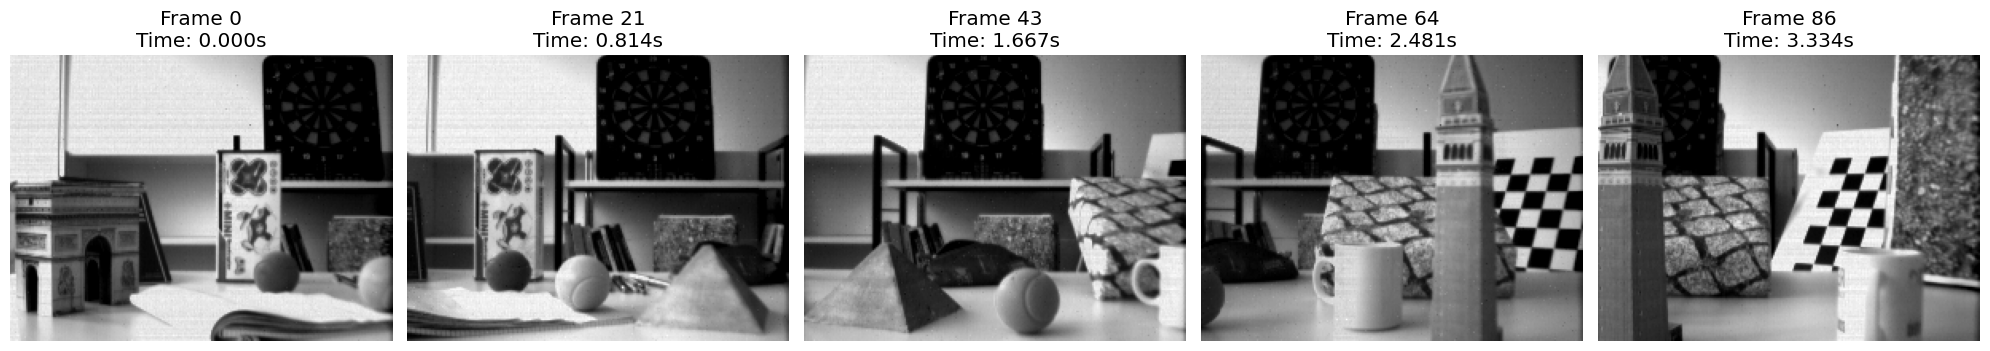

In [3]:
# Let's display a few ground truth images to see what we're working with
def display_images(img_paths, num_images=5):
    """Display a subset of ground truth images"""
    indices = np.linspace(0, len(img_paths)-1, num_images, dtype=int)
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    
    for i, idx in enumerate(indices):
        img_path = os.path.join(data_path, img_paths[idx])
        img = np.array(Image.open(img_path))
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Frame {idx}\nTime: {img_timestamps[idx]:.3f}s")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display a few ground truth images
display_images(img_paths)

## 2. Basic Event Visualization

Before reconstructing video, let's visualize the events to understand what we're working with.

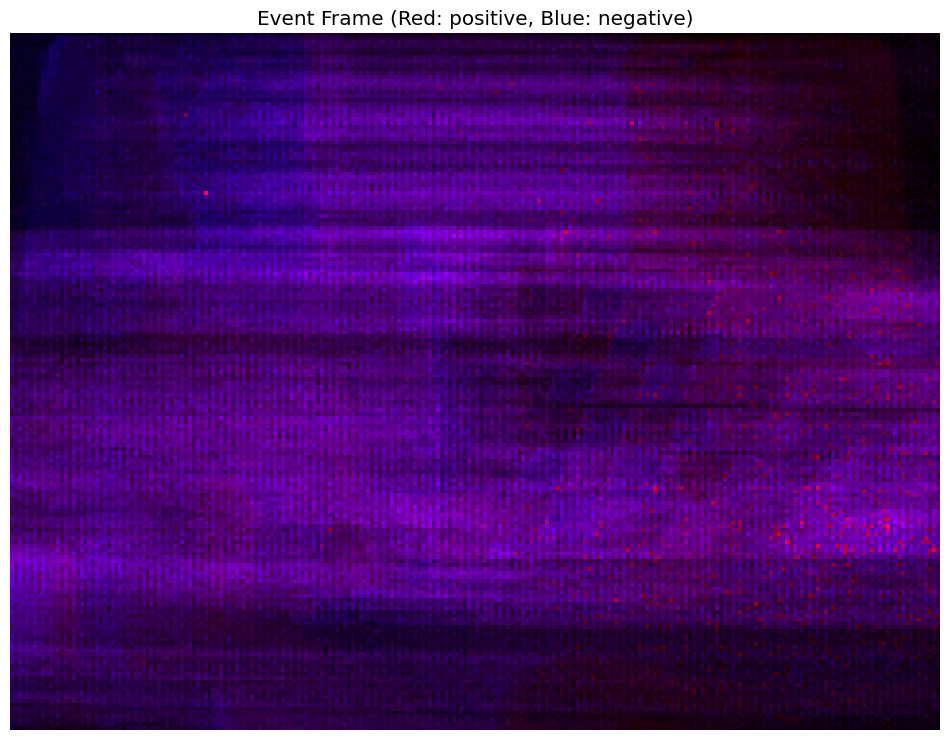

In [4]:
def create_event_frame(xs, ys, ps, resolution, mode="polarity", normalize=True):
    """Create an event frame with different accumulation modes"""
    width, height = resolution
    
    if mode == "polarity":
        # Accumulate polarities (positive and negative)
        frame = np.zeros((height, width), dtype=np.float32)
        for x, y, p in zip(xs, ys, ps):
            if 0 <= x < width and 0 <= y < height:
                frame[y, x] += p
    
    elif mode == "count":
        # Count events regardless of polarity
        frame = np.zeros((height, width), dtype=np.float32)
        for x, y in zip(xs, ys):
            if 0 <= x < width and 0 <= y < height:
                frame[y, x] += 1
    
    elif mode == "separate":
        # Create separate channels for positive and negative events
        frame = np.zeros((height, width, 3), dtype=np.float32)
        for x, y, p in zip(xs, ys, ps):
            if 0 <= x < width and 0 <= y < height:
                if p > 0:
                    frame[y, x, 0] += 1  # Red for positive
                else:
                    frame[y, x, 2] += 1  # Blue for negative
        
        # Normalize each channel separately if requested
        if normalize:
            for c in range(3):
                if frame[:,:,c].max() > 0:
                    frame[:,:,c] /= frame[:,:,c].max()
            return frame
    
    # Normalize frame if requested
    if normalize and frame.max() > 0:
        frame = frame / frame.max()
    
    return frame

# Create and visualize event frame
event_frame = create_event_frame(xs, ys, ps, (sensor_width, sensor_height), mode="separate")
plt.figure(figsize=(12, 10))
plt.imshow(event_frame)
plt.title("Event Frame (Red: positive, Blue: negative)")
plt.axis('off')
plt.show()

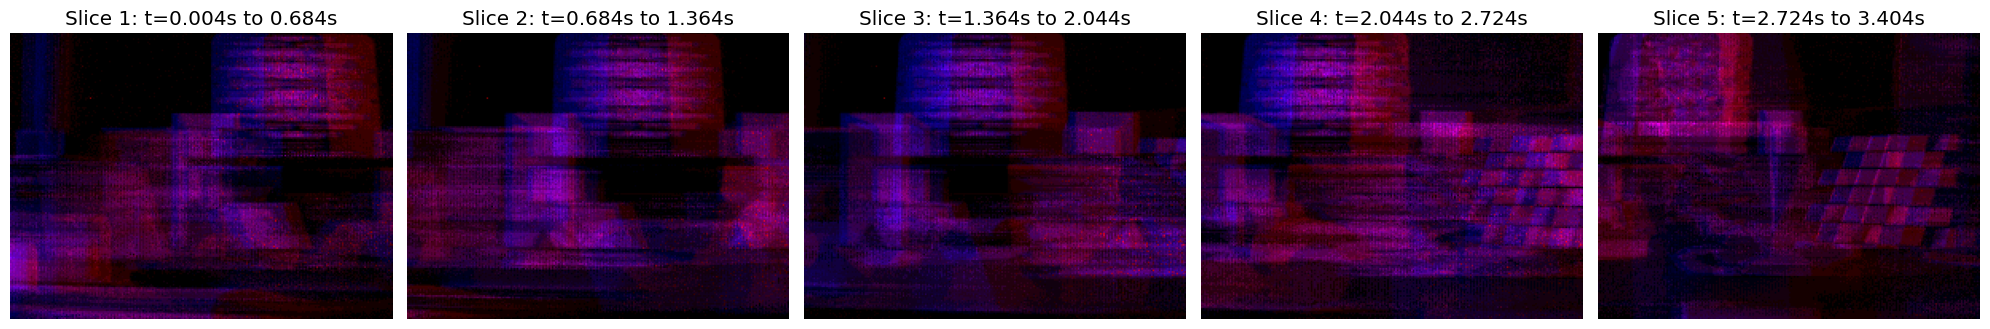

In [5]:
def create_event_slices(xs, ys, ts, ps, resolution, num_slices=10):
    """Split events into time slices and create visualization for each"""
    width, height = resolution
    
    # Calculate time range and bin edges
    t_min, t_max = ts.min(), ts.max()
    bins = np.linspace(t_min, t_max, num_slices + 1)
    
    slices = []
    for i in range(num_slices):
        t_start, t_end = bins[i], bins[i+1]
        idx = (ts >= t_start) & (ts < t_end)
        
        # Extract events in this time slice
        slice_xs = xs[idx]
        slice_ys = ys[idx]
        slice_ps = ps[idx]
        
        # Create image for this slice
        frame = create_event_frame(slice_xs, slice_ys, slice_ps, (width, height), mode="separate")
        slices.append((frame, t_start, t_end))
    
    return slices

# Create event slices to visualize temporal evolution
event_slices = create_event_slices(xs, ys, ts, ps, (sensor_width, sensor_height), num_slices=5)

# Visualize the slices
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, (frame, t_start, t_end) in enumerate(event_slices):
    axes[i].imshow(frame)
    axes[i].set_title(f"Slice {i+1}: t={t_start:.3f}s to {t_end:.3f}s")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 3. Reconstructing Video from Events

Now let's use EVLib's event-to-video reconstruction capability to convert the events to frames.

In [ ]:
# Define a custom workaround for multi-frame reconstruction 
def custom_reconstruct_events_to_frames(xs, ys, ts, ps, height, width, num_frames, num_bins=5):
    """
    Custom function to reconstruct multiple frames from events
    
    This is a workaround for the type mismatch issue in the built-in function.
    It uses the single-frame reconstruction function repeatedly.
    """
    # Get time range
    t_min, t_max = ts.min(), ts.max()
    time_step = (t_max - t_min) / num_frames
    
    # List to store frames
    frames = []
    
    for i in range(num_frames):
        # Define time window for this frame
        t_end = t_min + time_step * (i + 1)
        
        # Get events up to this time
        mask = ts <= t_end
        frame_xs = xs[mask]
        frame_ys = ys[mask]
        frame_ts = ts[mask]
        frame_ps = ps[mask]
        
        # Skip if no events
        if len(frame_xs) == 0:
            # Empty frame
            empty_frame = np.zeros((height, width, 1), dtype=np.float32)
            frames.append(empty_frame)
            continue
        
        # Process events using the working single-frame function
        frame = evlib.processing.events_to_video(
            frame_xs, frame_ys, frame_ts, frame_ps,
            height=height,
            width=width,
            num_bins=num_bins
        )
        
        frames.append(frame)
    
    return frames

# Reconstruct video from events using evlib with our workaround
print("Reconstructing video frames from events...")
reconstructed_frames = custom_reconstruct_events_to_frames(
    xs, ys, ts, ps, 
    height=int(sensor_height), 
    width=int(sensor_width), 
    num_frames=20,  # Generate 20 evenly spaced frames
    num_bins=5      # Number of time bins for the voxel grid
)

print(f"Generated {len(reconstructed_frames)} reconstructed frames")

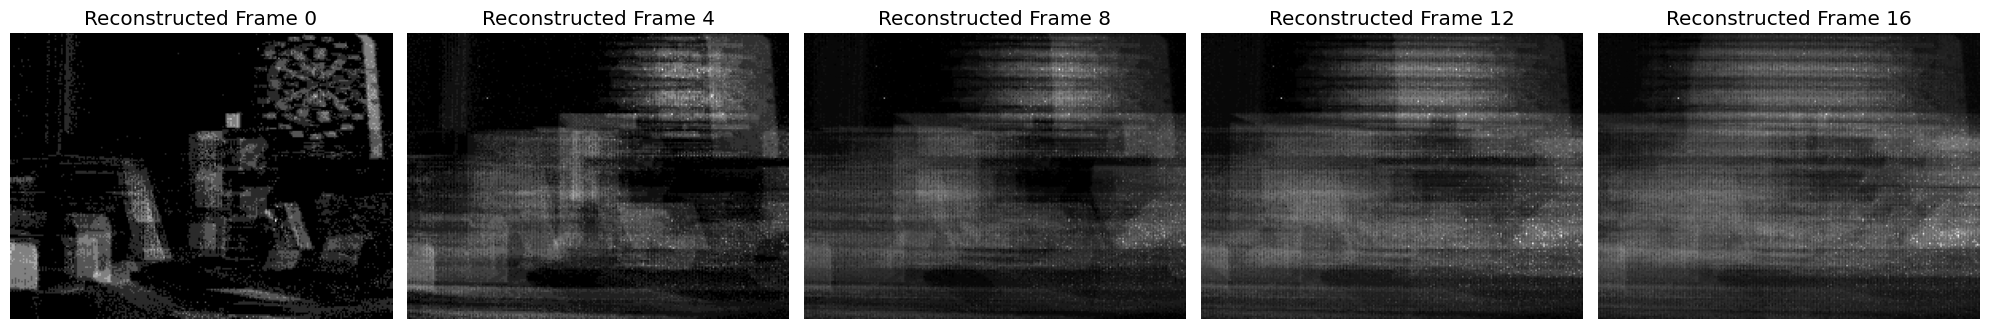

In [7]:
# Display a few reconstructed frames
num_to_show = min(5, len(reconstructed_frames))
fig, axes = plt.subplots(1, num_to_show, figsize=(20, 4))

for i in range(num_to_show):
    idx = i * len(reconstructed_frames) // num_to_show
    frame = reconstructed_frames[idx]
    
    # Convert to grayscale if 3D array with single channel
    if len(frame.shape) == 3 and frame.shape[2] == 1:
        frame = frame[:, :, 0]
    
    axes[i].imshow(frame, cmap='gray')
    axes[i].set_title(f"Reconstructed Frame {idx}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 4. Creating and Saving a Video

Now let's create a video from the reconstructed frames.

In [8]:
# Create an animation of the reconstructed frames
def create_frame_animation(frames):
    """Create an animation from a list of frames"""
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.close()  # Don't display the empty figure
    
    # Preprocess frames to ensure they're all 2D grayscale
    processed_frames = []
    for frame in frames:
        # Convert to grayscale if 3D array with single channel
        if len(frame.shape) == 3 and frame.shape[2] == 1:
            frame = frame[:, :, 0]
        processed_frames.append(frame)
    
    # Initialize with first frame
    im = ax.imshow(processed_frames[0], cmap='gray')
    ax.set_title("Reconstructed Video")
    ax.axis('off')
    
    def update(frame_idx):
        im.set_array(processed_frames[frame_idx])
        return [im]
    
    ani = animation.FuncAnimation(fig, update, frames=len(processed_frames), blit=True, interval=100)
    return ani

# Create animation
reconstructed_animation = create_frame_animation(reconstructed_frames)

# Display in the notebook
HTML(reconstructed_animation.to_jshtml())

In [9]:
if have_cv2:
    # Save the reconstructed frames as a video
    output_path = 'reconstructed_video.mp4'
    fps = 10
    
    # Convert frames to uint8 format for OpenCV
    frames_uint8 = []
    for frame in reconstructed_frames:
        # Convert to grayscale if 3D array with single channel
        if len(frame.shape) == 3 and frame.shape[2] == 1:
            frame = frame[:, :, 0]
        
        # Normalize and convert to uint8
        if frame.max() > frame.min():
            frame = (frame - frame.min()) / (frame.max() - frame.min())
        frame_uint8 = (frame * 255).astype(np.uint8)
        
        # Convert to RGB format for video
        frame_rgb = cv2.cvtColor(frame_uint8, cv2.COLOR_GRAY2RGB)
        frames_uint8.append(frame_rgb)
    
    # Create and initialize video writer
    height, width = frames_uint8[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Write frames to video
    for frame in frames_uint8:
        out.write(frame)
    
    # Release the video writer
    out.release()
    
    print(f"Video saved to {output_path}")
else:
    print("OpenCV not available - cannot save video")

Video saved to reconstructed_video.mp4


## 5. Comparing with Ground Truth Images

Let's compare the reconstructed frames with the ground truth images from the dataset.

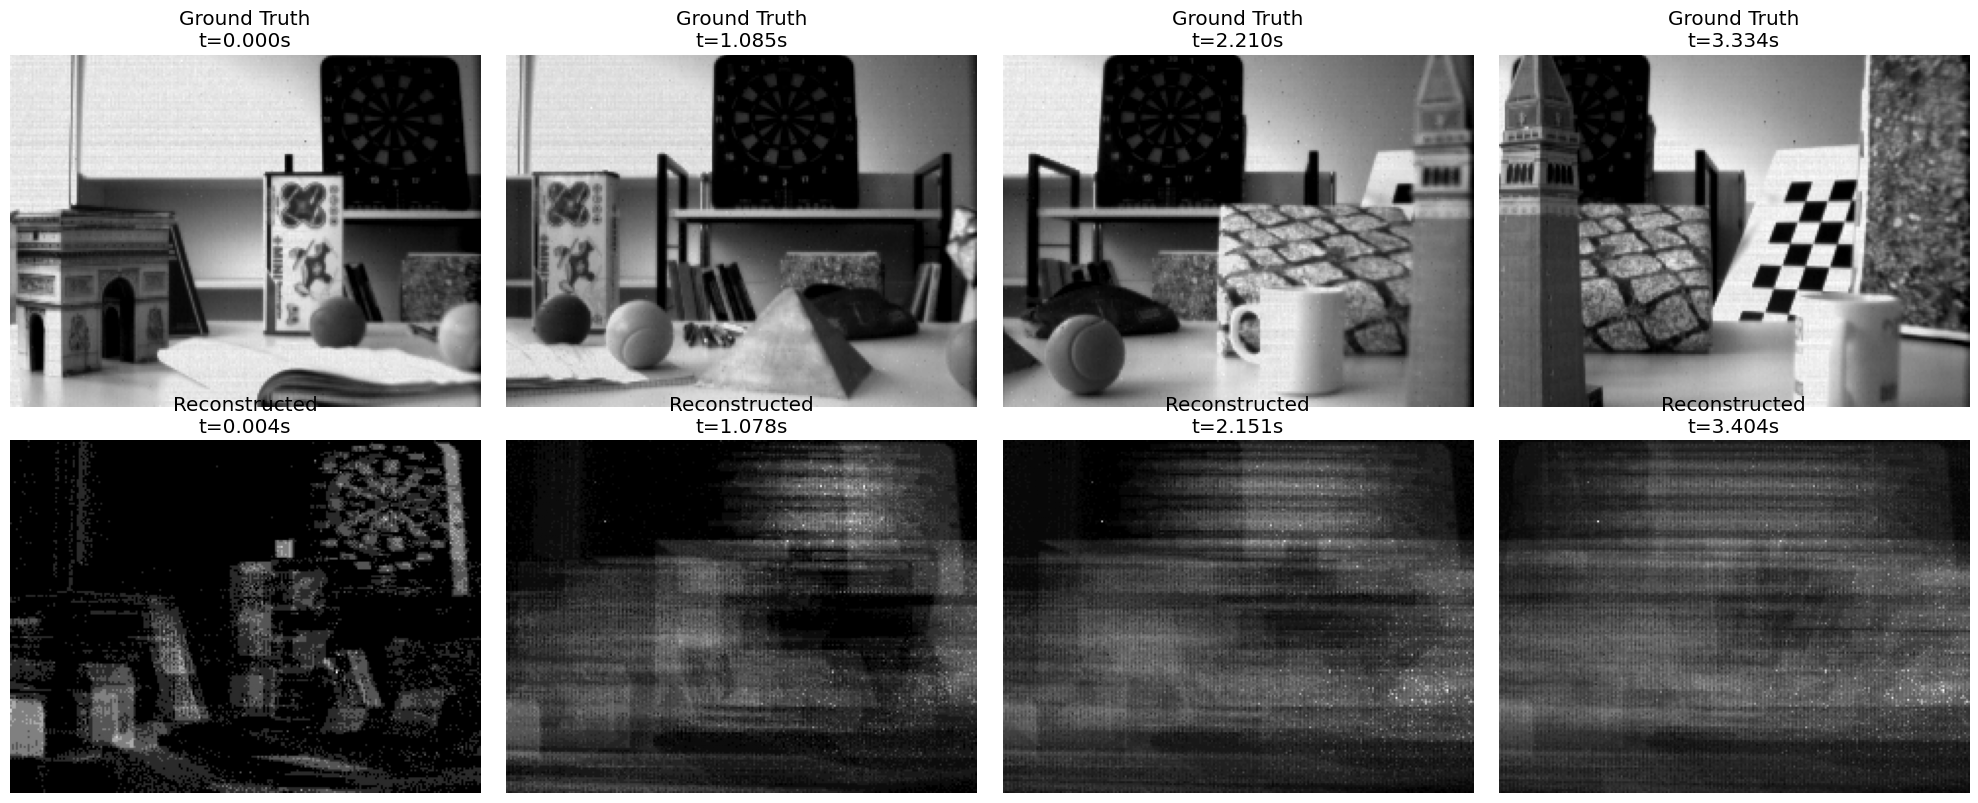

In [10]:
def compare_reconstruction_with_groundtruth(reconstructed_frames, img_paths, img_timestamps, ts):
    """Compare reconstructed frames with ground truth images"""
    # Select frames to compare (ground truth images at roughly equally spaced intervals)
    num_comparisons = min(4, len(reconstructed_frames), len(img_paths))
    gt_indices = np.linspace(0, len(img_paths)-1, num_comparisons, dtype=int)
    
    # Calculate the timestamp for each reconstructed frame
    t_min, t_max = ts.min(), ts.max()
    recon_timestamps = np.linspace(t_min, t_max, len(reconstructed_frames))
    
    # Create a figure for comparisons
    fig, axes = plt.subplots(2, num_comparisons, figsize=(20, 8))
    
    for i, gt_idx in enumerate(gt_indices):
        # Ground truth frame
        gt_path = os.path.join(data_path, img_paths[gt_idx])
        gt_time = img_timestamps[gt_idx]
        gt_img = np.array(Image.open(gt_path))
        
        # Find closest reconstructed frame by timestamp
        closest_idx = np.argmin(np.abs(recon_timestamps - gt_time))
        recon_frame = reconstructed_frames[closest_idx]
        recon_time = recon_timestamps[closest_idx]
        
        # Convert to grayscale if 3D array with single channel
        if len(recon_frame.shape) == 3 and recon_frame.shape[2] == 1:
            recon_frame = recon_frame[:, :, 0]
        
        # Display ground truth
        axes[0, i].imshow(gt_img, cmap='gray')
        axes[0, i].set_title(f"Ground Truth\nt={gt_time:.3f}s")
        axes[0, i].axis('off')
        
        # Display reconstructed frame
        axes[1, i].imshow(recon_frame, cmap='gray')
        axes[1, i].set_title(f"Reconstructed\nt={recon_time:.3f}s")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Compare reconstructed frames with ground truth
compare_reconstruction_with_groundtruth(reconstructed_frames, img_paths, img_timestamps, ts)

## 6. Single-Frame Event-to-Video Reconstruction

Now let's demonstrate how to reconstruct a single frame from events within a specific time window.

In [ ]:
# Select a time window from the middle of the dataset
t_min, t_max = ts.min(), ts.max()
t_mid = (t_min + t_max) / 2
window_size = 0.5  # seconds

# Filter events in the window
mask = (ts >= t_mid - window_size/2) & (ts <= t_mid + window_size/2)
window_xs = xs[mask]
window_ys = ys[mask]
window_ts = ts[mask]
window_ps = ps[mask]

print(f"Selected {len(window_xs)} events in the time window {t_mid - window_size/2:.3f}s to {t_mid + window_size/2:.3f}s")

# Reconstruct a single frame from the selected events
reconstructed_frame = evlib.processing.events_to_video(
    window_xs, window_ys, window_ts, window_ps, 
    height=int(sensor_height), 
    width=int(sensor_width), 
    num_bins=5  # Number of time bins for the voxel grid
)

# Find the closest ground truth frame for comparison
closest_gt_idx = np.argmin(np.abs(np.array(img_timestamps) - t_mid))
gt_path = os.path.join(data_path, img_paths[closest_gt_idx])
gt_img = np.array(Image.open(gt_path))

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ground truth frame
axes[0].imshow(gt_img, cmap='gray')
axes[0].set_title(f"Ground Truth\nt={img_timestamps[closest_gt_idx]:.3f}s")
axes[0].axis('off')

# Reconstructed frame
if len(reconstructed_frame.shape) == 3 and reconstructed_frame.shape[2] == 1:
    reconstructed_frame = reconstructed_frame[:, :, 0]
axes[1].imshow(reconstructed_frame, cmap='gray')
axes[1].set_title(f"Reconstructed\nt={t_mid:.3f}s")
axes[1].axis('off')

# Event frame for comparison
event_frame = create_event_frame(window_xs, window_ys, window_ps, (sensor_width, sensor_height), mode="separate")
axes[2].imshow(event_frame)
axes[2].set_title(f"Event Frame\n({len(window_xs)} events)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 7. Conclusion

In this notebook, we demonstrated how to use EVLib to reconstruct video frames from event data. We showed:

1. Loading and visualizing event data from the slider_depth dataset
2. Creating a custom workaround for multi-frame reconstruction to avoid a type mismatch issue
3. Reconstructing multiple frames to create a video from events
4. Reconstructing a single frame from a specific time window of events
5. Comparing reconstructed frames with ground truth images

**Note on the workaround:** The built-in `evlib.processing.reconstruct_events_to_frames_py` function has a type mismatch issue (it expects F64 but receives F32), so we implemented a custom workaround that uses the working single-frame function `evlib.processing.events_to_video_py` repeatedly to generate multiple frames.

Event-to-video reconstruction is a valuable tool for working with event camera data, as it converts the sparse, asynchronous events into a more familiar video format that can be used with traditional computer vision algorithms.